In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda
from hyperiax.models.functional import pass_up
from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter
from matplotlib import pyplot as plt
import jax

In [3]:
key = PRNGKey(0)

# Estimation of inner nodes of an evolutionary tree

In this notebook we illustrate how to use Hyperiax for estimating inner nodes of a phylogenetic tree, given 

- observations of the leaf-nodes and
- knowledge of the tree topology (number of nodes, the edges connecting them and edge lengths).

This is a basic problem in the field of Phylogenetic Comparative Methods.
We will be particularly interested in the root-node estimate, which can be interpreted as the phylogenetic mean of the observations. 
We will use a very simple estimator of the inner nodes; any inner node will be estimated as the weighted mean of its children. I.e. $x = \sum_{i=1}^k c_i \cdot 1/w_i$, where $w_i$ is the length of the edge between the inner node $x$ and its child $c_i$. We assume that all nodes are 2-dimensional vectors, which allows for nice visualizations.

Furthermore we show how to use Hyperiax for simulating trees (i.e. inner nodes and leaf nodes) based on the Brownian motion model; an edge of length T corresponds to a Brownian motion run for a duration of T. This allows us to evaluate our estimates of inner nodes since we know the true values in this case.

**Content of the notebook**

1. we create the tree with a chosen topology
2. we simulate node values, based on the Brownian motion model
3. we estimate inner nodes based on a simulated tree
4. we show how to compute the estimations more conveniently using 'prebuilt' functions


### 1. Creating the Tree

First, we initialize a tree. This creates a tree with a chosen topology. This topology is a "stupid" class, in the sense that it contains no data - and only serves as a representation of the data we intend to work on.

Setting `height=3` and `degree=2`, gives us a tree with 4 layers, where each node has `2` children

In [4]:
topology = symmetric_topology(height=3, degree=2)
plot_tree_text(topology)

       *
   ┌───┴───┐
   *       *   
 ┌─┴─┐   ┌─┴─┐ 
 *   *   *   * 
┌┴┐ ┌┴┐ ┌┴┐ ┌┴┐
* * * * * * * *


Hyperiax allows for fast computation using any backend supported by `JAX`. That means that if your operations are suitable, hyperiax will execute your code on the GPU automatically. To do this, hyperiax need to calcuate a series of offsets, and put your data on the correct format. All of this functionality is done with the `HypTree` class, we simply construct a tree from the topology.

Next, we need to specify which kind of data we intend to store in the tree. In this example we store 3 different values in each node, where the `noise` and `value` each are $2$ dimensional vectors, and `edge_length` is some scalar that represents the phylogenetic time between a node and its parent.

Under the hood, hyperiax will initialize buffers for all 3 values, stored in `tree.data` in a BFS order. All values are initialized to $0$.

In [5]:
tree = HypTree(topology)

tree.add_property('noise', shape=(2,))
tree.add_property('edge_length', shape=(1,))
tree.add_property('value', shape=(2,))

Lets say we now want to set the `edge_length` to be a decaying value as a function of the depth in the tree. Lets for the sake of example pick $l=exp(-ln(2)*d)$ where `d` is the depth of the node and `l` is the resulting `edge_length`. Each tree calculated the depth of each node, so we can use that here.

In [6]:
key, subkey = split(key)
tree.data['edge_length'] = jnp.exp(-jnp.log(2)*tree.node_depths)

This is an example of how we might use the underlying buffers to directly sample values for the entire tree. This is vastly more efficient than sample for one node at a time, and should be the preferred method.

Now, we can do the same for the 2 dimensional values we intent to store in `noise`.

In [7]:
key, subkey = split(key)
tree.data['noise'] = jax.random.normal(subkey, shape=tree.data['noise'].shape)

### 2. Simulating node values

Now we define a down function to correlate the nodes. Notice that since the `noise` in each node was sampled independently, they are currently just all iid. In this example, we define a down function which ensures that each child node of an inner node $x$ is a sample from a (standard) Brownian motion starting at $x$ and stopped at time $T$, where $T$ equals the length of the edge connecting $x$ and the child $c$. Such a sample can be obtained by computing $\sqrt{T} \cdot N + x$, where $N$ is a sample from a standard 2D Normal distribution. 

The `down` function operates on an edge $(u,v)$, where we let $u$ be the source node, and $v$ be the target node. If we are going downwards in the tree (as in this case), $u$ is the parent and $v$ is the child. The goal of the `down` function is to calculate the new value of $v$, using the data store in $u$ and $v$.

When hyperiax executes functions on a tree, it always has a sense of the _current_ node. In hyperiax terminology, when refering to a concrete property, for example the `noise` in an operation, we mean the `noise` stored in the _current_ node. When defining our own operations on a tree, we can query the data we need within nodes by specifying parameter names. In this case we need both the noise, and the edge length in the _current_ node. We do however, also need the result of the calculations done in the parent of each node. In hyperiax, all values stored in the _parent_ of the _current_ node, will be prefixed by `parent_`. In this case, we need the `parent_value`, since the result of our computation is named `value`, and we need the result stored in the _parent_.

Now, we want to set the value parameter in the node we just calculated. We do this by simply returning a dictionary specifying the values to overwrite. Notice, you do not need to return values you do not intend to change. In this example, we are not changing the edge lengths, and thus we just ignore them.

### 2. Simulating Node Values

To correlate the nodes, we define a `down` function. Initially, the `noise` in each node is sampled independently, making them independent and identically distributed (iid). We will create a `down` function to ensure that each child node of an inner node $x$ is a sample from a Brownian motion starting at $x$ and stopped at time $T$, where $T$ is the length of the edge connecting $x$ and the child $c$. This sample is calculated as $\sqrt{T} \cdot N + x$, with $N$ being a sample from a standard 2D Normal distribution.

In hyperiax, functions on a tree always consider the _current_ node. When referring to properties such as `noise`, it means the `noise` stored in the _current_ node. To define custom operations on a tree, we can query the necessary data within nodes by specifying parameter names. In this case, we need both the `noise` and the `edge_length` in the _current_ node. Additionally, we need the result of calculations from the parent node. In hyperiax, values stored in the _parent_ node are prefixed with `parent_`. For this computation, we need `parent_value` (the result of the computation in the parent node).

The implementation of the `down` function involves the following steps:

1. **Extract the necessary parameters**:
    - `noise`: the noise value in the _current_ node.
    - `edge_length`: the edge length stored in the _current_ node (this is by convention the length of the edge connecting the _current_ and _parent_ node)
    - `parent_value`: the result of the computation in the _parent_ node.

2. **Compute the new value for the child node**:
    - Calculate the new value as `sqrt(edge_length) * noise + parent_value`.

3. **Return the new value**:
    - Return a dictionary specifying the `value` parameter to overwrite in the child node $v$. Values that are not being changed, such as `edge_length`, can be omitted.

Hyperiax will greedily distribute you workloads, using vectorization among other techniques. This means that any down function is expected to work on batched data. In our example, the input shapes will be as follows;

- `noise`: `(b, 2)`.
- `edge_length`: `(b, 1)`.

Similarly, we need to return a batched output, in this case `value`, should have the shape `(b, 2)`, where `b` is some batch size determined by hyperiax.

If the concept of batching seems uncomfortable to you, we highly recommend using [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) which can do the batching for you automatically.

In [8]:
@jax.jit
def down(noise, edge_length,parent_value, **args):
    return {'value': jnp.sqrt(edge_length)*noise+parent_value}

Here, we set the root value to be the noise we sampled. All data is stored in BFS order in the buffers, this means that the root is always the first element.

In [9]:
tree.data['value'] = tree.data['value'].at[0].set(tree.data['noise'][0])

Now we create both an executor and a model. The model object contains all user code related to the operations we wish to run on a tree. The executor object schedules execution within the tree, and is in charge of setting the data in the correct format, as well as batching things together and making sure everything runs in the correct order.

You are welcome to define your operations as an entire class, in cases where a constructor is needed. In this example we use the anonymous lambda models from hyperiax, that lets you pass tree operations as arguments, such that they are ready to be executed on a tree directly.

We have now created a model that will generate brownian motion samples on a tree. The only thing left to do is give this model to an executor, which will run the code in the correct order on the tree. In this case we use the `OrderedExecutor`, since order is important for our operation. This executor will work on models going in either the up or down direction on a tree.

In [10]:
downmodel = DownLambda(down_fn=down)
exe = OrderedExecutor(downmodel)

With these objects created, we can now run our down function on the tree! Be careful as these operations are **INPLACE**. Because of this, we reccomend [idempotent](https://en.wikipedia.org/wiki/Idempotence) operations like here, where the result is stored in `value`, instead of overwriting `noise`(notice how this would give a different result for each execution).

In [11]:
exe.down(tree)

Besides topology visualizations, hyperiax also provides avenues of displaying the underlying data in the tree. When dealing with $2$ dimensional vectors, we can perform a classic scatter plot, but with the tree topology overlaid.

Note that passing in a pyplot axis object is optional, if you do not wish to use your own, then it can be omitted.

Using these two plots, we can see how the `down` function infact seems to correlate our nodes!

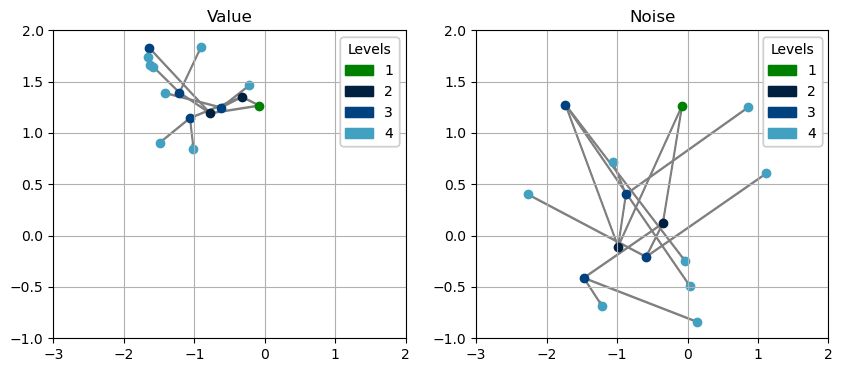

In [12]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-3,2)
    a.set_ylim(-1,2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'noise', ax=ax[1])
ax[1].set_title('Noise');

The green node represents the root, and the light blue nodes represent the leafs.

### 3. Estimating the inner nodes

Now we are going to mask out all of the data on the internal nodes, since we would often only know the `value` in the leaf nodes. The tree class has a boolean mask that indicates whether or not a node is a leaf obtainable via `tree.leaves`.

First, we get the leaf data by simply indexing with the mask. Next, we overwrite the leaf values in `estimated_value` with the concrete observations from `leaf_data`

In [13]:
tree.add_property('estimated_value', shape=(2,))
leaf_data = tree.data['value'][tree.leaves]
tree.data['estimated_value'] = tree.data['estimated_value'].at[tree.leaves].set(leaf_data)

We now define 2 operations and a reduction.

The `up` function takes the value in a _current_ node, and forms a message that is passed toward its _parent_.

The `reductions` parameter of the `UpLambda` class, determines how each property should be reduced when multiple are incoming from the _child_ nodes. In this case we have `sum` for both arguments. This means that after a message is sent from each child toward its parent, each property is first summed before the `transform` operation in the _parent_.

The `transform` function processes the reduced incoming messages of the _child_ nodes, and treats the recieving node of the messages as the _current_ node. This means that we need to use the prefix `child_` when getting the reduced values of the children.



# Upward Pass Computation

In this section, we explore the upward pass computation in hyperiax, where values propagate from the leaves of a tree toward the root. This process consists of two primary operations (`up` and `transform`) and a reduction step.

## Overview

1. **Up Operation (`up` function)**:
   - **Purpose**: To generate a message at each node that will be passed to its parent.
   - **Inputs**: Values specific to the current node.
   - **Outputs**: A message containing the processed values to be sent to the parent node.

2. **Reduction (`reductions` parameter)**:
   - **Purpose**: To aggregate messages from multiple child nodes.
   - **Inputs**: Messages from the child nodes.
   - **Outputs**: A single aggregated message that combines the values from all child nodes using a specified reduction method (e.g., sum).

3. **Transform Operation (`transform` function)**:
   - **Purpose**: To process the aggregated message at the parent node.
   - **Inputs**: Aggregated messages from the child nodes aswell as the values in the _current_ node.
   - **Outputs**: A transformed value for the parent node.

## Explanation of the example

### 1. Up Operation (`up` function)

The `up` function takes the value at the current node and forms a message that will be passed to the parent node. 

When hyperiax executes functions on a tree, it always has a sense of the _current_ node. In hyperiax terminology, when referring to a specific property, such as `estimated_value`, it means the `estimated_value` stored in the _current_ node.

- **Parameters**:
  - `estimated_value`: The value associated with the current node.
  - `edge_length`: The length of the edge connecting the current node to its parent.
  - `**kwargs`: Any additional arguments that might be needed.
- **Returns**: A dictionary with two properties:
  - `weighted_value`: Calculated as `estimated_value / edge_length`.
  - `inverse_edge_length`: Calculated as `1 / edge_length`.

In this case, with $w_i=1/l_i$ with $l_i$ being the edge length in node $i$. We can write the inner node estimation $p$ as a sum over children $c_i$

$$p=\frac{1}{\sum w_i}\sum c_iw_i$$

The key is to observe that we can compute $\sum w_i$ and $\sum c_iw_i$ independently, where we use the sum as a reduction and $w_i$ and $w_ic_i$ are the messages being passed up

### 2. Reduction (`reductions` parameter)

The reduction step determines how to combine multiple messages received from child nodes. In this example, we use the sum operation for both `weighted_value` and `inverse_edge_length` properties.

- **`weighted_value`**: The messages' `weighted_value` properties from all child nodes are summed.
- **`inverse_edge_length`**: The messages' `inverse_edge_length` properties from all child nodes are summed.

### 3. Transform Operation (`transform` function)

The `transform` function processes the aggregated message at the parent node. It uses the reduced values from the child nodes to compute a new value for the current (parent) node.

- **Parameters**:
  - `child_weighted_value`: The aggregated `weighted_value` from all child nodes.
  - `child_inverse_edge_length`: The aggregated `inverse_edge_length` from all child nodes.
  - `**kwargs`: Any additional arguments that might be needed.
- **Returns**: A dictionary with one property:
  - `estimated_value`: Calculated as `child_weighted_value / child_inverse_edge_length`.

## Putting It All Together

To set up the upward pass, we define an `UpLambda` model with the `up` and `transform` functions, and the specified reductions.

- **`UpLambda`**: Initializes the upward pass model with the `up` and `transform` functions and the reduction rules.
- **`OrderedExecutor`**: Executes the upward pass using the defined model.

This setup ensures that values propagate correctly from the leaves to the root, are aggregated at each step, and transformed to provide the final values at each node.

By following this process, you can effectively implement and understand the upward pass computation in hyperiax.


In [14]:
def transform(child_weighted_value,child_inverse_edge_length, **kwargs):
    return {'estimated_value': child_weighted_value/child_inverse_edge_length}

def up(estimated_value, edge_length, **kwargs):
    return {'weighted_value': estimated_value/edge_length, 'inverse_edge_length':1/edge_length}
upmodel = UpLambdaReducer(up, transform, 
                   reductions={
                       'weighted_value': 'sum', 
                       'inverse_edge_length': 'sum'
                    }
        )
upward_exe = OrderedExecutor(upmodel)

In [15]:
upward_exe.up(tree)

And we can plot the estimated tree as follows

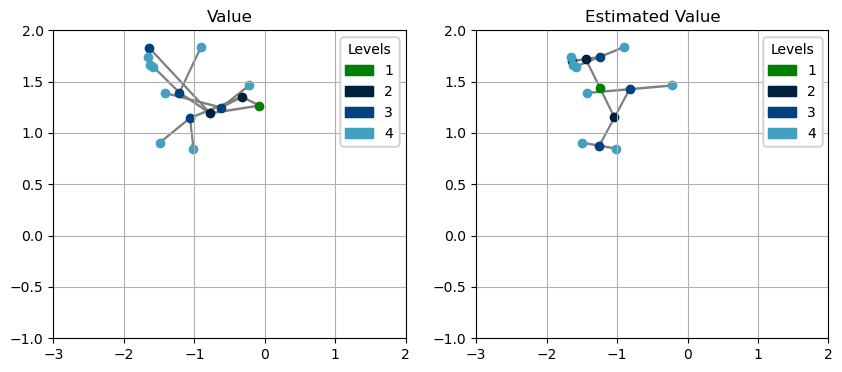

In [16]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for a in ax:
    a.set_xlim(-3,2)
    a.set_ylim(-1,2)
plot_tree_2d_scatter(tree, 'value', ax=ax[0])
ax[0].set_title('Value')
plot_tree_2d_scatter(tree, 'estimated_value', ax=ax[1])
ax[1].set_title('Estimated Value');

### 4. Using prebuilts

Alternatively, we can use the cool prebuilts to do the same computations as above, but more conveniently!

In [17]:
from hyperiax.models.prebuilts import PhyloMeanModel

The `PhyloMeanExecutor` expects leaf nodes to all contain a field called `estimated_value`. Since we already know the exact values here, we can simply set them directly

In [18]:
pme = PhyloMeanModel()
exe = OrderedExecutor(pme)

In [19]:
exe.up(tree)